## Using scMKL with single-cell RNA Data
To run tutorials, install `plotnine` and `jupyter` into your scMKL env with `pip install plotnine jupyter`.
Here we will run scMKL on a subset of the MCF-7 data (1,000 cells x 36,601 genes) using Hallmark groupings.

### Importing Modules
Data is read-in and saved using Numpy and SciPy modules.

In [1]:
import scmkl

# Packages needed to import data
import numpy as np
from scipy.sparse import load_npz

# Modules for viewing results
import pandas as pd
from plotnine import *

### Reading in Data
There are four pieces of data (per modality) required for scMKL:
- The data matrix itself with cells as rows and features as columns.
    - Can be either a Numpy array or SciPy sparse array (scipy.sparse.csc_array is the recommended format).  
- The sample labels in a Numpy array. To perform group lasso, these labels must be binary.
- Feature names in a Numpy array. These are the names of the features corresponding with the data matrix columns.
- A dictionary with grouping data.  The keys are the names of the groups, and the values are the corresponding features.
    - Example: {Group1: [feature1, feature2, feature3], Group2: [feature4, feature5, feature6], ...}.
    - See `getting_RNA_groupings.ipynb` for more information on pulling gene sets.

In [2]:
# Reading in grouping dictionary from pickle file
group_dict = np.load('./data/RNA_hallmark_groupings.pkl', allow_pickle = True)

# Reading in data to be analyzed
X = load_npz('./data/MCF7_RNA_X.npz')
cell_labels = np.load('./data/MCF7_cell_labels.npy', allow_pickle = True)
feature_names = np.load('./data/MCF7_RNA_feature_names.npy', allow_pickle = True)

# D is the number of dimensions per group
# Previous literature shows the calculation below yields optimal number of dimensions
D = int(np.sqrt(len(cell_labels)) * np.log(np.log(len(cell_labels))))

### Creating an AnnData Object
scMKL takes advantage of AnnData's flexible structure to create a straight-forward approach to running scMKL. Using `scmkl.create_adata()` will create an AnnData object from input data that will include necessary variables for running scMKL. For more information, see scMKL's [documentation](https://ohsu-cedar-comp-hub.github.io/scMKL/).

In [3]:
adata = scmkl.create_adata(X = X, 
                         feature_names = feature_names, 
                         cell_labels = cell_labels, 
                         group_dict = group_dict,
                         D = D
                         )

### Estimating Kernel Widths
`sigma` refers to kernel widths and should be estimated with `estimate_sigma()`.

In [4]:
adata = scmkl.estimate_sigma(adata, n_features = 200)

### Calculating Z
The Z matrices are a the Fourier transform of the grouped data matrix. This is calculated on training and testing samples separately. 

Returns Z matrices for training and testing in adata object with `adata.uns['Z_train']` and `adata.uns['Z_test']`.

In [5]:
adata = scmkl.calculate_z(adata, n_features = 5000)

### Optimizing Sparsity
Sparsity (lambda) or alpha here, is the regularization coefficient that controls the pentalty to run with the model. 

This will ultimately decide how many groups will be used in the final model.

`scmkl.optimize_alpha()` returns a single sparsity value as the optimal sparsity argument for training the model.

In [7]:
# Setting a list of alpha values to train the model with
alpha_list = np.round(np.linspace(2.2,0.05,10), 2)

# Calculating the best performing alpha from cross validation on training data
alpha_star = scmkl.optimize_alpha(adata = adata, alpha_array = alpha_list, k = 4)

### Training and Evalutating Model
Here we will train and evaluate 10 models, each with a different `alpha`.

`alpha` (or lambda) is a regularization coefficient that deterimines how many groupings will be used to classify the test cells in the final model. Here, we will evalutate the model using a range of alphas (`alpha_list`) to get a range of selected groups.

In [8]:
results = scmkl.run(adata = adata, alpha_list = alpha_list)

  Evaluating model. Alpha: 2.2
  Evaluating model. Alpha: 1.96
  Evaluating model. Alpha: 1.72
  Evaluating model. Alpha: 1.48
  Evaluating model. Alpha: 1.24
  Evaluating model. Alpha: 1.01
  Evaluating model. Alpha: 0.77
  Evaluating model. Alpha: 0.53
  Evaluating model. Alpha: 0.29
  Evaluating model. Alpha: 0.05


### Model Performance and Top Groups per Alpha

In [9]:
summary_df = scmkl.get_summary(results)
summary_df

,Alpha,AUROC,Number of Selected Groups,Top Group
0,2.20,0.7745,1,HALLMARK_G2M_CHECKPOINT
1,1.96,0.8629,3,HALLMARK_G2M_CHECKPOINT
2,1.72,0.9050,4,HALLMARK_G2M_CHECKPOINT
3,1.48,0.9362,6,HALLMARK_ESTROGEN_RESPONSE_EARLY
4,1.24,0.9569,8,HALLMARK_ESTROGEN_RESPONSE_EARLY
5,1.01,0.9675,9,HALLMARK_ESTROGEN_RESPONSE_EARLY
6,0.77,0.9730,11,HALLMARK_ESTROGEN_RESPONSE_EARLY
7,0.53,0.9793,20,HALLMARK_ESTROGEN_RESPONSE_EARLY
8,0.29,0.9832,34,HALLMARK_ESTROGEN_RESPONSE_EARLY
9,0.05,0.9824,50,HALLMARK_ESTROGEN_RESPONSE_EARLY


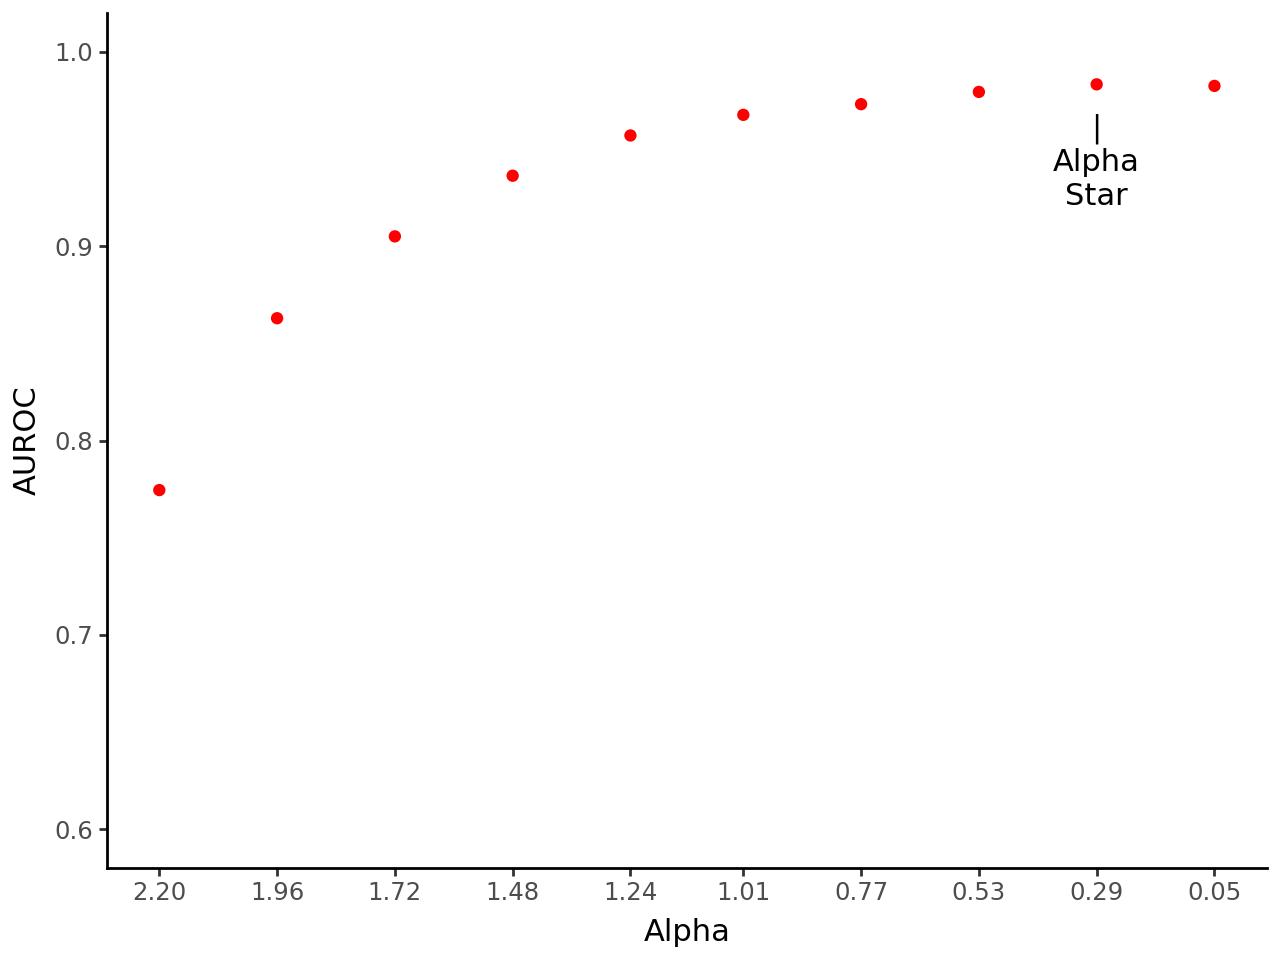

In [10]:
metric_plot = scmkl.plot_metric(summary_df, color = 'red', alpha_star = alpha_star)
metric_plot.show()

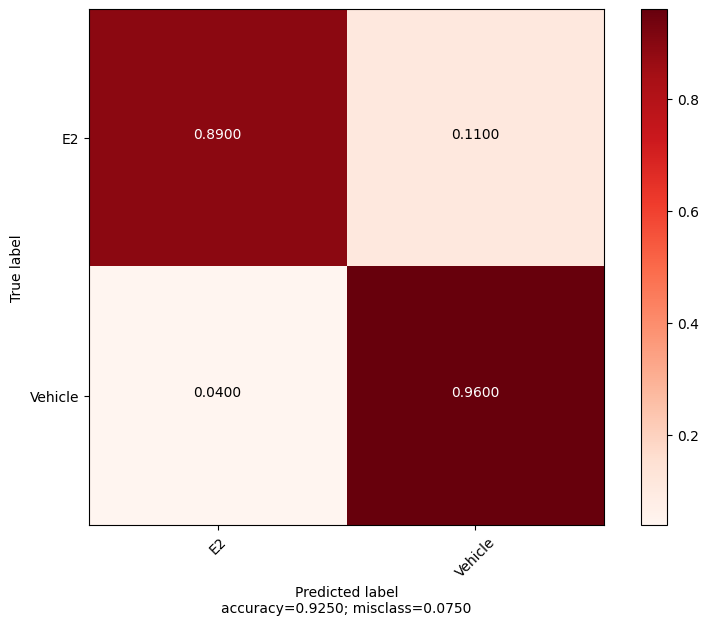

In [ ]:
from matplotlib.pyplot import get_cmap

scmkl.plot_conf_mat(results, title = '', cmap = get_cmap('Reds'))